In [1]:
import pandas as pd
import json
from pandas.io.json import json_normalize
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import numpy as np
font = {
#         'weight' : 'bold',
        'size'   : 13}

plt.rc('font', **font)

In [2]:
LOGS_PATH = '../logs'
PERFORMANCE_THRESHOLD = 0.85

In [3]:
objs_in_path = listdir(LOGS_PATH)
data_paths = [join(LOGS_PATH, f) for f in objs_in_path if isfile(join(LOGS_PATH, f)) and 'log' in f]

In [4]:
logs = []
for path in data_paths:
    with open(path) as f:
        d = json.load(f)
    logs.append(json_normalize(d))
data = pd.concat(logs, axis=0)
data = data[data['accuracy_test'] > PERFORMANCE_THRESHOLD]

In [5]:
data.shape

(3, 17)

In [6]:
data.columns

Index(['accuracy_-1_test', 'accuracy_-1_train', 'accuracy_-1_val',
       'accuracy_1_test', 'accuracy_1_train', 'accuracy_1_val',
       'accuracy_test', 'accuracy_train', 'accuracy_val', 'end_time',
       'losses_train', 'losses_val', 'n_workers', 'running_mode',
       'running_time', 'start_time', 'sync_epochs'],
      dtype='object')

In [7]:
data.running_mode.value_counts()

asynchronous    2
synchronous     1
Name: running_mode, dtype: int64

In [8]:
data.groupby(['running_mode', 'n_workers']).size()

running_mode  n_workers
asynchronous  3            2
synchronous   3            1
dtype: int64

In [9]:
data['n_workers'] = data['n_workers'].astype(int)

In [10]:
sync = data[data['running_mode'] == 'synchronous'].sort_values('n_workers')
a_sync = data[data['running_mode'] == 'asynchronous'].sort_values('n_workers')

In [11]:
def seconds(x, pos):
    return '{} s'.format(int(x))

formatter_s = FuncFormatter(seconds)

def percentage(x, pos):
    return '{}%'.format(int(x*100))

formatter_p = FuncFormatter(percentage)

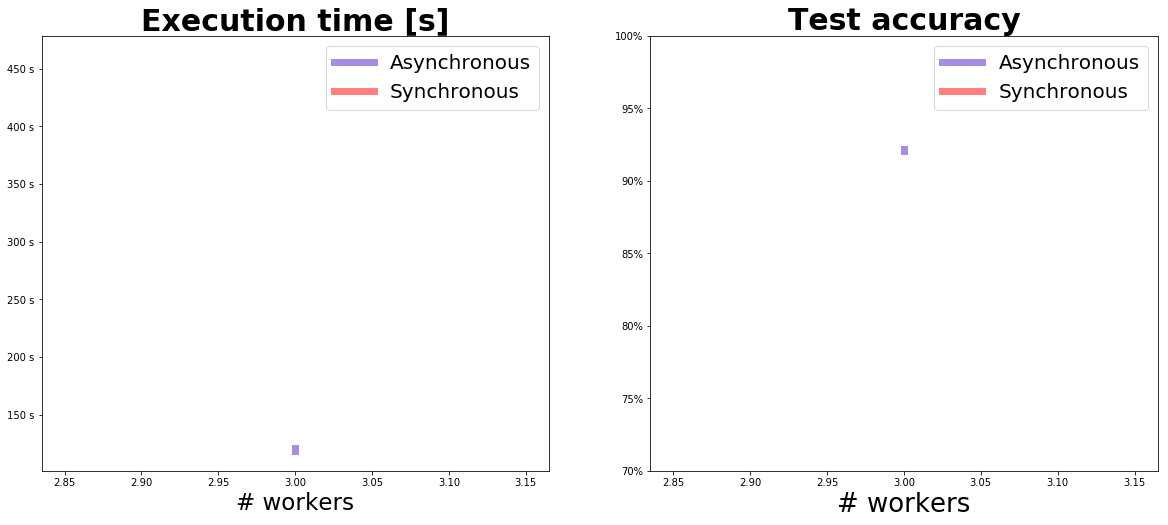

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8), sharex=True)
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)

v = ['running_time', 'accuracy_test']

ax[0].plot(a_sync['n_workers'], a_sync[v[0]], color='#9370DB', alpha=0.8, linewidth=7.0);
ax[0].plot(sync['n_workers'], sync[v[0]], color='red', alpha=0.5, linewidth=7.0);
ax[0].yaxis.set_major_formatter(formatter_s)
ax[0].legend(['Asynchronous', 'Synchronous'], fontsize=20);
ax[0].set_title('Execution time [s]', fontsize=30, fontweight='bold')
ax[0].set_xlabel('# workers', fontsize=23);
# ax[0].set_ylabel('time [s]', fontsize=23);

ax[1].plot(a_sync['n_workers'], a_sync[v[1]], color='#9370DB', alpha=0.8, linewidth=7.0);
ax[1].plot(sync['n_workers'], sync[v[1]], color='red', alpha=0.5, linewidth=7.0);
ax[1].yaxis.set_major_formatter(formatter_p)
ax[1].legend(['Asynchronous', 'Synchronous'], fontsize=20);
ax[1].set_title('Test accuracy', fontsize=30, fontweight='bold')
ax[1].set_xlabel('# workers', fontsize=26);
# ax[1].set_ylabel('accuracy', fontsize=26);
ax[1].set_ylim([0.7,1]);

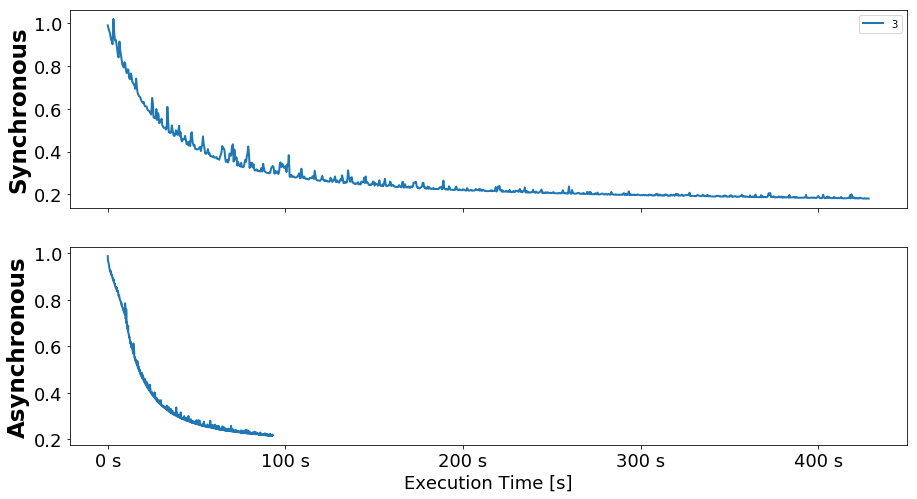

In [14]:
N = [3]
fig, ax = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

for n in N:
    sync_loss_val = pd.DataFrame(sync[sync.n_workers == n]['losses_val'].values[0])
    sync_loss_val['seconds'] = (pd.to_datetime(sync_loss_val['time']) - pd.to_datetime(sync_loss_val['time'].min())).astype(np.int64) / 10**9
    ax[0].plot(sync_loss_val['seconds'], sync_loss_val['loss_val'], linewidth=2);
    
    async_loss_val = pd.DataFrame(a_sync[a_sync.n_workers == n]['losses_val'].values[0])
    async_loss_val['seconds'] = (pd.to_datetime(async_loss_val['time']) - pd.to_datetime(async_loss_val['time'].min())).astype(np.int64) / 10**9
    ax[1].plot(async_loss_val['seconds'], async_loss_val['loss_val'], linewidth=2);
    
    
ax[0].legend(N)
ax[1].xaxis.set_major_formatter(formatter_s);
ax[1].set_xlabel('Execution Time [s]', fontsize=18);
ax[0].set_ylabel('Synchronous', fontsize=23, fontweight='bold');
ax[1].set_ylabel('Asynchronous', fontsize=23, fontweight='bold');

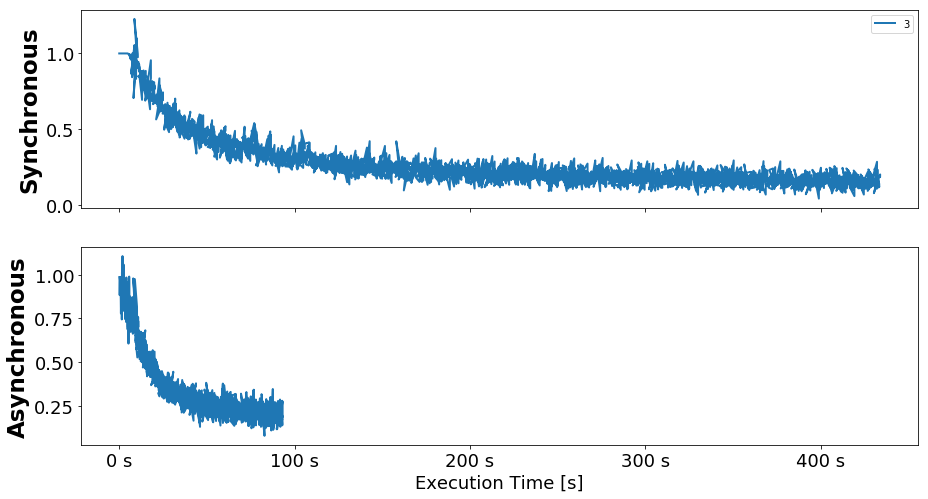

In [15]:
N = [3]
fig, ax = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

for n in N:
    sync_loss_val = pd.DataFrame(sync[sync.n_workers == n]['losses_train'].values[0])
    sync_loss_val['seconds'] = (pd.to_datetime(sync_loss_val['time']) - pd.to_datetime(sync_loss_val['time'].min())).astype(np.int64) / 10**9
    ax[0].plot(sync_loss_val['seconds'], sync_loss_val['loss_train'], linewidth=2);
    
    async_loss_val = pd.DataFrame(a_sync[a_sync.n_workers == n]['losses_train'].values[0])
    async_loss_val['seconds'] = (pd.to_datetime(async_loss_val['time']) - pd.to_datetime(async_loss_val['time'].min())).astype(np.int64) / 10**9
    ax[1].plot(async_loss_val['seconds'], async_loss_val['loss_train'], linewidth=2);
    
    
ax[0].legend(N)
ax[1].xaxis.set_major_formatter(formatter_s);
ax[1].set_xlabel('Execution Time [s]', fontsize=18);
ax[0].set_ylabel('Synchronous', fontsize=23, fontweight='bold');
ax[1].set_ylabel('Asynchronous', fontsize=23, fontweight='bold');